
# Desafío Spike - Energía

El objetivo de este notebook es crear un estimador para la desviaciòn de precios del sistema eléctrico chileno. Para esto consideraremos las siguientes secciones 

## Secciones y objetivos específicos 
1. Costos marginales <br>
    Realizar un análisis exploratorio de las bases de datos del costo marginal real y programado.
2. Construcción de variables <br>
    Explorar la variación entre los costos reales y programados
3. Visualización de datos <br>
    Analizar los costos para barras especificas y buscar barras sin costo real
4. Base para los modelos <br>
    Realizar un análisis exploratorio de la base para la predicción y crear características nuevas
5. Predicción de desviaciones del costo marginal: modelo 1 <br>
    Entrenar un modelo de predicción para la desviación de los costos programados con respecto a los costos reales a la hora siguiente.
6. Predicción de desviaciones del costo marginal: modelo 2 <br>
      Entrenar un modelo de predicción similar al anterior pero con un delay de los datos de 12 horas.
7. Merge con datos de clima: modelo 3 <br>
    Incorporar al modelo anterior los datos del clima 
8. Reflexión



# Funciones para gráficas y import de paquetes
Antes de comenzar con el desafio, en la siguiente celda se inicializan los paquetes utilizados más utilizados y las funciones para gráficar

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import classification_report


def time_plot_costo_barra( codigo_barra, fecha_inicial, fecha_final):
    fig, ax = plt.subplots(figsize=(20, 10))
    df = costo_marginal
    
    query = (df.barra_mnemotecnico == codigo_barra) &\
            (df.fecha <= fecha_final) & (df.fecha >= fecha_inicial)
    df_plot = df[query]
    
    plt.plot(df_plot.fecha, df_plot.costo_programado, color = "blue",marker="o",markersize = 2, label="Costo Programado")
    plt.plot(df_plot.fecha, df_plot.costo_real, color = "orange",marker="o",markersize = 2, label="Costo Real")

    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)

    plt.grid()
   
    plt.title("Costos marginales para la barra "+codigo_barra+" entre "+ fecha_inicial+" y "+fecha_final)
    plt.xlabel("Fecha")
    plt.ylabel("Costo (clp)")
    
    plt.xticks(rotation=0)
    ax.legend()
    plt.show()
   

def plot_mean_std(df,var_x,var_y):
    fig, ax = plt.subplots(figsize=(20, 10))
    
    mean = df.groupby(var_x).agg({var_y:"mean"}).reset_index().rename(columns={var_y:"mean"})
    std = df.groupby(var_x).agg({var_y:"std"}).reset_index().rename(columns={var_y:"std"})
    df_plot = pd.merge(mean,std,on=var_x)
    
    plt.plot(df_plot[var_x], df_plot["mean"], color = "blue",marker="o",markersize = 5, label="training accuracy")
    plt.fill_between(df_plot[var_x],df_plot["mean"] + df_plot["std"],df_plot["mean"] - df_plot["std"],alpha=0.15,color="blue")


    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)

    plt.grid()
   
    plt.xlabel(var_x)
    plt.ylabel("Media "+var_y)
    plt.title(var_x+" v/s "+var_y)
    
    if var_x == "barra_mnemotecnico":
        rotacion = 90
    else:
        rotacion = 0
    plt.xticks(rotation=rotacion)
    
    plt.show()

    
def time_plot_prediccion(subestacion, var_y, fechas):
    fig, ax = plt.subplots(figsize=(20, 10))
    df = prediccion
    df.sort_values(by = "hora",inplace=True)
    for fecha in fechas:
        
        query = (df.nemotecnico_se == subestacion) & (df.fecha == fecha)
        df_plot = df[query]
        
        plt.plot(df_plot.hora, df_plot[var_y],marker="o",markersize = 2, label=fecha)

    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)

    plt.grid()
   
    plt.title("Serie de tiempo para "+var_y)
    plt.xlabel("Hora")
    plt.ylabel(var_y)
    
    ax.legend()
    plt.show()
    

def curva_lift(y_pred_prob,y_pred,y_test):
    lift = pd.DataFrame()
    lift["y_pred"] = y_pred
    lift["probs"] = y_pred_prob
    lift.reset_index(inplace = True, drop = True)
    lift["y_test"] = y_test["target"].values
    lift["ratio_bien"] = lift.apply(lambda x: 1 if x.y_pred == x.y_test else 0,axis = 1)
    lift["decile"] =pd.qcut(lift['probs'], 10, labels = False) 

    lift.sort_values(by = "probs", inplace =True)
    lift.groupby("decile").agg({"ratio_bien":"mean"}).rename(columns={"ratio_bien":"lift"}).plot(legend = "lift")
    ax = plt.gca()
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)

    plt.xlabel("Decil")
    plt.ylabel("Promedio Aciertos")
    plt.title("Curva de lift")
    plt.legend(loc="best")
    plt.show()
    
    
def plot_classification_analysis(clf,X_test,y_test,y_pred,y_pred_prob):
    
    #### Curva de lift 
    curva_lift(y_pred_prob,y_pred,y_test)
    #### Métricas
    print(classification_report(y_test, y_pred, target_names=["desvio","no_desvio"]))
    
    ##### Curva ROC
    fp, tp, thres = roc_curve(y_test, y_pred)
    roc_auc = auc(fp, tp)
    plt.plot(fp, tp, label=f"ROC AUC (área = {round(roc_auc,2)})")
    plt.plot([0, 1], [0, 1], color="r", linestyle="--")
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel("Falsos Positivos")
    plt.ylabel("Verdaderos Positivos")
    plt.title("Curva ROC")
    plt.legend(loc="best")
    ax = plt.gca()
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)

    # Matriz de confusión
    class_names = ["No hay desvio","Hay desvio"]
    disp = plot_confusion_matrix(clf, X_test, y_test,
                                 display_labels=class_names,normalize ="true")
    disp.ax_.set_title("Matriz de confusión normalizada")
    plt.show()



# 1. Costos marginales
## Vista general de la base y barras
A continuación cargamos la base de datos de costos marginales y programados y las juntamos. Además, eliminamos los duplicados:

In [2]:
costo_marginal_programado = pd.read_csv("../data/costo_marginal_programado.csv") 
costo_marginal_real = pd.read_csv("../data/costo_marginal_real.csv") 



costo_marginal_real.rename(columns = {"costo_en_pesos":"costo_real","costo_en_dolares":"costo_real_dolares"},inplace=True)
costo_marginal_programado.rename(columns={"costo":"costo_programado","mnemotecnico_barra":"barra_mnemotecnico"},inplace=True)

### merge
costo_marginal = pd.merge(costo_marginal_real,costo_marginal_programado, on=["barra_mnemotecnico","fecha","hora"])

#botamos los duplicados
costo_marginal_real.drop_duplicates(subset=["barra_mnemotecnico","fecha","hora"],inplace=True)

## transformamos la fecha a datetime
costo_marginal.fecha = pd.to_datetime(costo_marginal.fecha)


costo_marginal.sort_values(by = ["barra_mnemotecnico","fecha","hora"],inplace= True)
costo_marginal.head()

,barra_mnemotecnico,barra_referencia_mnemotecnico,fecha,hora,costo_real_dolares,costo_real,nombre,nombre_barra,costo_programado
33176,BA01G004SE001T011,BA02T002SE032T002,2019-01-01,1,50.41,35.06973,BA S/E CANDELARIA B1 - 220KV,BA S/E CANDELARIA B1 - 220KV,50.116286
71356,BA01G004SE001T011,BA02T002SE032T002,2019-01-01,2,50.41,35.06973,BA S/E CANDELARIA B1 - 220KV,BA S/E CANDELARIA B1 - 220KV,50.522836
109429,BA01G004SE001T011,BA02T002SE032T002,2019-01-01,3,49.40,34.36709,BA S/E CANDELARIA B1 - 220KV,BA S/E CANDELARIA B1 - 220KV,50.119505
147309,BA01G004SE001T011,BA02T002SE032T002,2019-01-01,4,48.56,33.78271,BA S/E CANDELARIA B1 - 220KV,BA S/E CANDELARIA B1 - 220KV,49.854087
185370,BA01G004SE001T011,BA02T002SE032T002,2019-01-01,5,46.51,32.35654,BA S/E CANDELARIA B1 - 220KV,BA S/E CANDELARIA B1 - 220KV,49.854087


In [3]:
print("La fecha mínima de observaciones es :" ,costo_marginal.fecha.min())
print("La fecha mínima de observaciones es :" ,costo_marginal.fecha.max())

La fecha mínima de observaciones es : 2019-01-01 00:00:00
La fecha mínima de observaciones es : 2019-06-30 00:00:00


In [4]:
print("La bases tienen el siguiente número de columunas:")
print("Costo_marginal_real: ",costo_marginal_real.shape[0])
print("Costo_marginal_programado: ",costo_marginal_programado.shape[0])
print("Costo_marginal: ",costo_marginal.shape[0])

La bases tienen el siguiente número de columunas:
Costo_marginal_real:  4309951
Costo_marginal_programado:  1192124
Costo_marginal:  913388


In [5]:
print("Barras con costo real:")
print(costo_marginal_real.barra_mnemotecnico.nunique())
print("Barras con costo programado:")
print(costo_marginal_programado.barra_mnemotecnico.nunique())
print("Barras con costo real y costo programado:")
print(costo_marginal.barra_mnemotecnico.nunique())

barras_anomalas = list(set(costo_marginal_programado.barra_mnemotecnico)-set(costo_marginal_real.barra_mnemotecnico))

print("Las siguientes son barras que no tienen costo real pero si costo programado:",len(barras_anomalas))
print(barras_anomalas)

Barras con costo real:
1020
Barras con costo programado:
239
Barras con costo real y costo programado:
220
Las siguientes son barras que no tienen costo real pero si costo programado: 19
['BA16T002SE009T002', '-', 'BA02R002SE007R002', 'BA01L050SE001T002', 'BA02T003SE029T003', 'BA02G004SE017G004', 'BA22L120SE114L120', 'BA02T002SE012T002', 'BA01L011SE009L011', 'BA01G006SE002G006', 'BA06T002SE008T002', 'BA01R002SE050R002', 'BA01L011SE028L011', 'BA03R002SE010R002', 'BA08T002SE003T002', 'BA05T005SE005T005', 'BA01L011SE027L011', 'BA02T003SE002T003', 'BA04R002SE014R002']


En conclusión:
1. Se programa el costo para 239 barras
2. Hay 219 barras que aparecen en la barra, que corresponden al 21.4 % de las barras con costo real.
3. Desaparecen 19 barras que tienen costo programado y no tienen costo real
4. Hay observaciones desde el 1ro de enero hasta el 30 de junio del 2019

## Estadísticas descriptivas e histogramas

Las estadísticas descriptivas de la base resultante arroja los siguientes resultados 
1. La media del costo programado es más alto que el costo real (más de un 60 %)
2. Hay costos programados negativos
3. Todos los costos reales son  positivos
4. La desviación estandar en ambos costos es similar
5. Todas las horas del dia tienen la misma cantidad de observaciones, 38049, salvo  la hora 25, con 212 observaciones
6. La mayoría de las observaciones del costo real están bajo 40 
7. La mayoría de las observaciones del costo programado están sobre 50 
8. La distribución de costo programado tiene una cola más larga y la distribución de costo real está más concentrada

In [6]:
costo_marginal.describe()

,hora,costo_real_dolares,costo_real,costo_programado
count,913388.000000,913388.000000,913388.000000,913388.000000
mean,12.502901,58.566654,39.512227,61.888004
std,6.924006,23.276453,15.555780,23.806896
min,1.000000,0.000000,0.000000,-12.113677
25%,7.000000,48.440000,32.559880,49.981588
50%,13.000000,53.330000,35.965290,55.057527
75%,19.000000,60.890000,41.258260,64.181228
max,25.000000,791.140000,523.418220,610.600000


In [7]:
costo_marginal.hora.value_counts()

13    38049
12    38049
2     38049
3     38049
4     38049
5     38049
6     38049
7     38049
8     38049
9     38049
10    38049
11    38049
1     38049
24    38049
14    38049
15    38049
16    38049
17    38049
18    38049
19    38049
20    38049
21    38049
22    38049
23    38049
25      212
Name: hora, dtype: int64

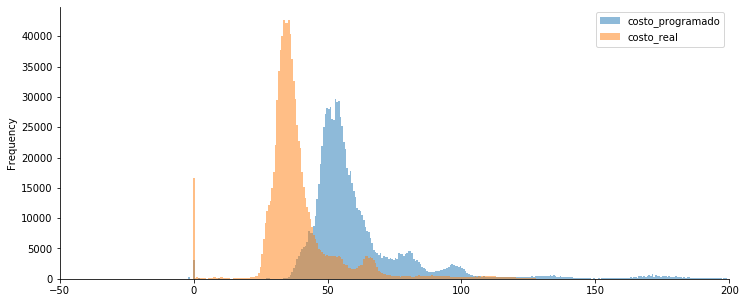

In [8]:
ax = costo_marginal[["costo_programado","costo_real"]].plot.hist(bins = 1000,grid=False, figsize=(12,5),alpha =0.5, xlim=(-50,200))
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)


## Costos medios 
Otra vista interesante de las variables se puede obtener al mirar el promedio y la desviación estandar de los costos por fecha y por hora. De esta vista, las conclusiones más importantes que podemos sacar son:
1. En la vista de costos por fecha, se pueden observar ciclos semanales.
2. No se observan difrencias significativas entre los costos programados y reales.
3. En la vista de costos por hora, podemos observar ciclos diarios que tienen su peak entre la hora 20 y 25.


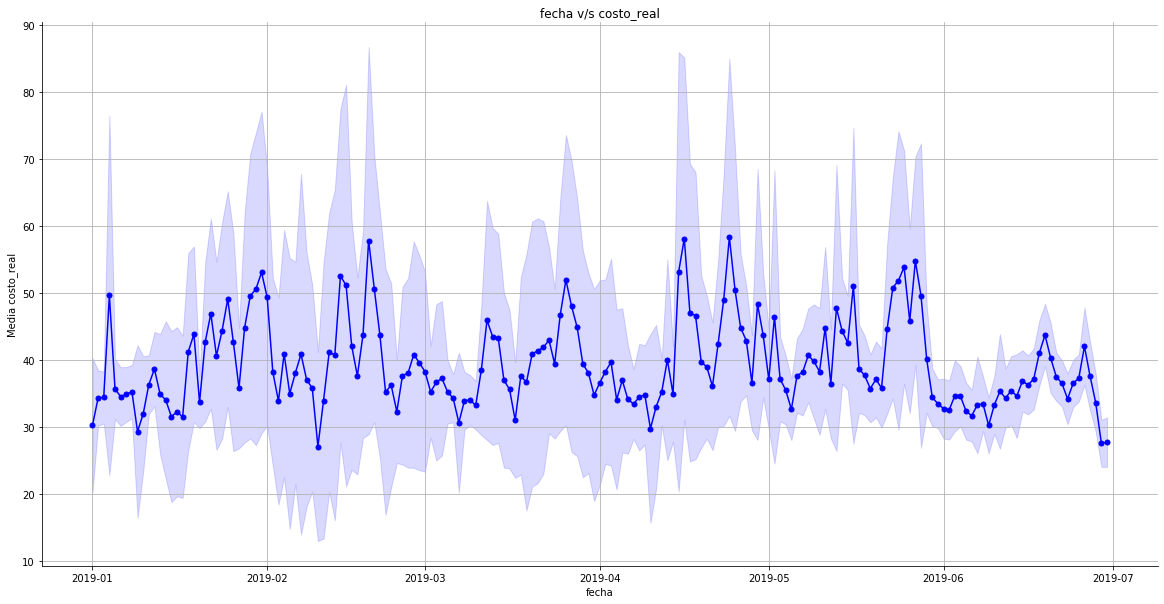

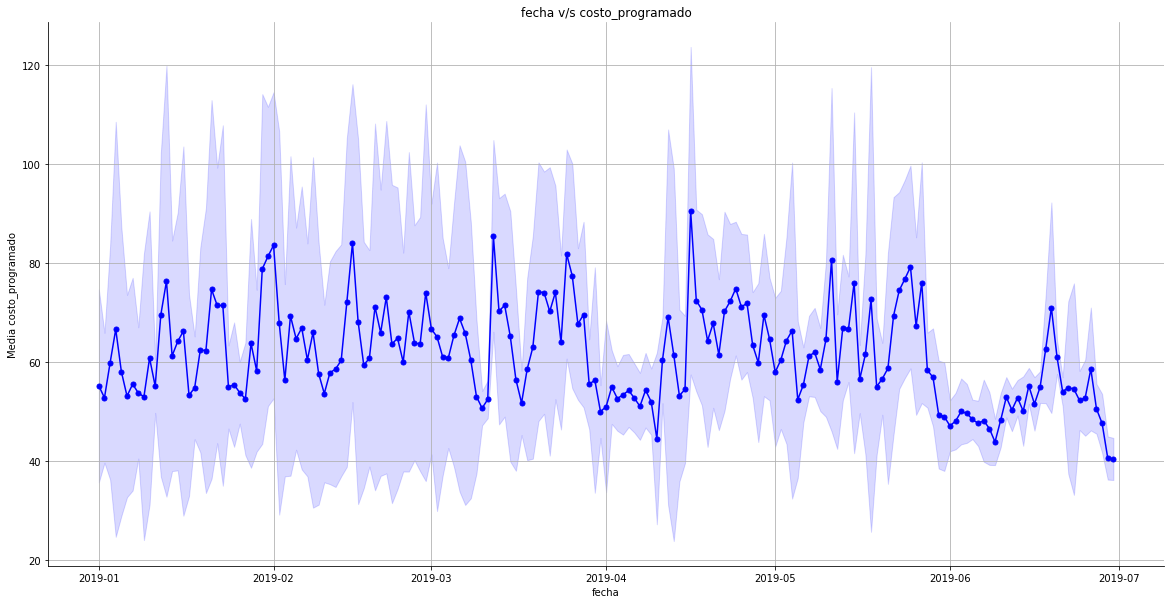

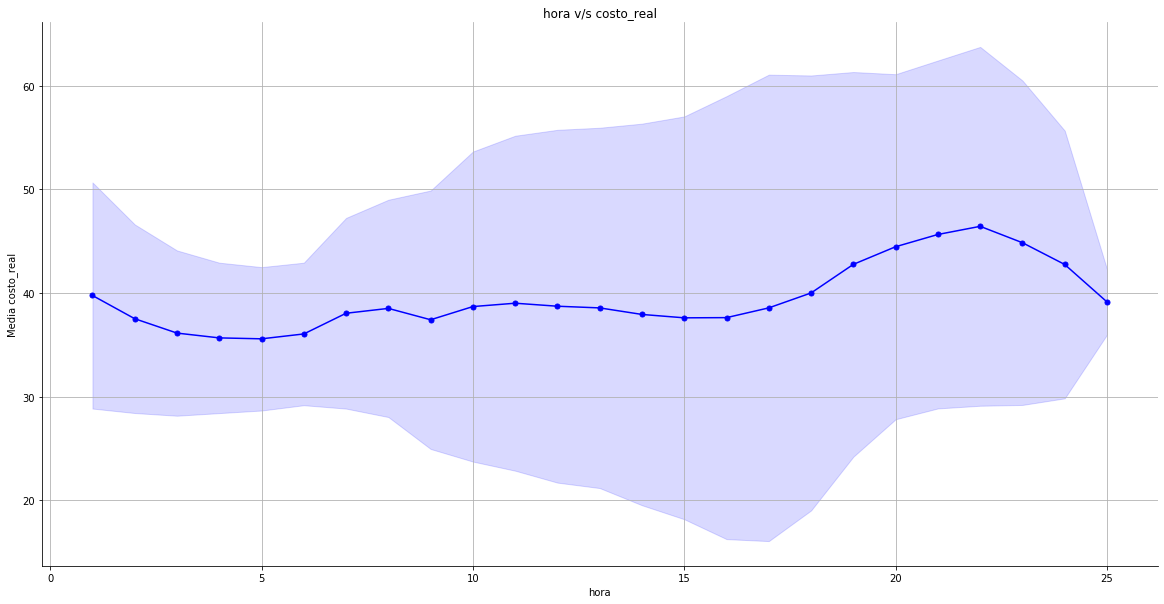

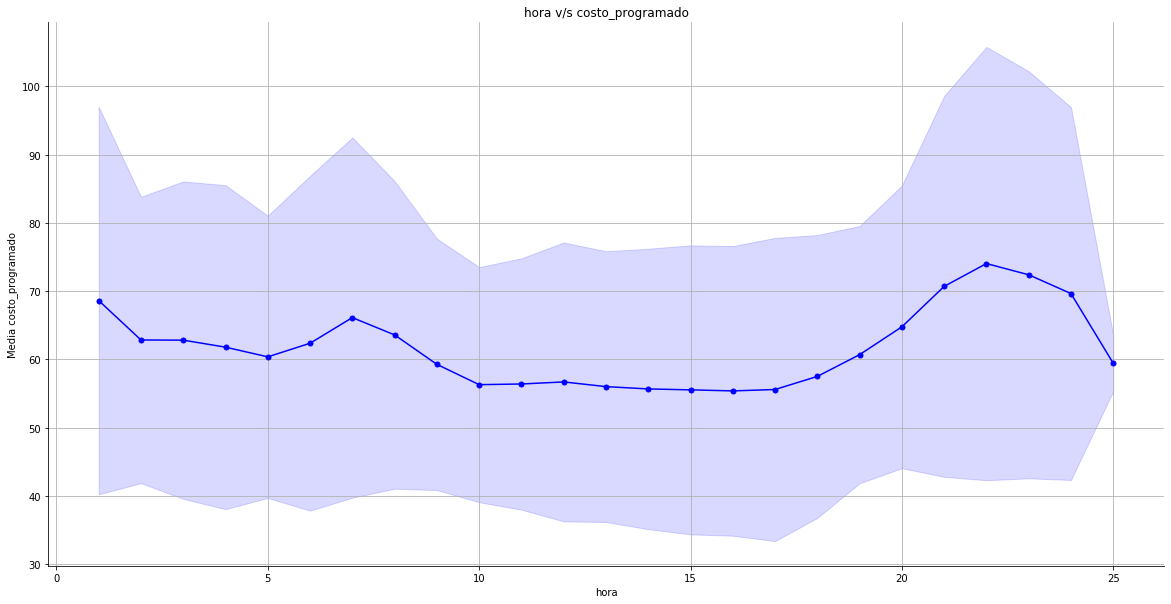

In [9]:
plot_mean_std(costo_marginal,"fecha","costo_real")
plot_mean_std(costo_marginal,"fecha","costo_programado")

plot_mean_std(costo_marginal,"hora","costo_real")
plot_mean_std(costo_marginal,"hora","costo_programado")




# 2. Construcción de variables
A continuación construiremos las variables desviacion_pct y desviacion_cat

In [10]:
costo_marginal["desviacion"] = costo_marginal.costo_real-costo_marginal.costo_programado
costo_marginal["desviacion_pct"] = costo_marginal.desviacion/costo_marginal.costo_real*100
costo_marginal["desviacion_cat"] = costo_marginal.desviacion_pct.map(lambda x: 1 if abs(x)>15 else 0)

Utilizando la variable desviacion_cat concluimos que en la base costo_marginal hay un 96% de costos programados que se desvian más de un 15% del costo real. 

In [11]:
costo_marginal.desviacion_cat.value_counts()/costo_marginal.desviacion_cat.value_counts().sum()*100

1    96.000276
0     3.999724
Name: desviacion_cat, dtype: float64

Como lo hicimos en la sección anterior, otra vista interesante de las variable desviacion_pct se puede obtener al mirar el promedio y la desviación estandar por fecha, por hora y por barra. De estas vistas, las conclusiones más importantes que podemos sacar son:
1. Si miramos fecha vs desvacion_pct, en la mayoria de los dias los costos programados son mayores que los costos reales
2. Si miramos hora vs desvacion_pct, los costos reales son mayores solo entre las horas 10 y 20. 

3. Si miramos barra_mnemotecnico vs desvacion_pct, podemos observar hay un grupo de barras que tienen un costo más alto y menos estable.



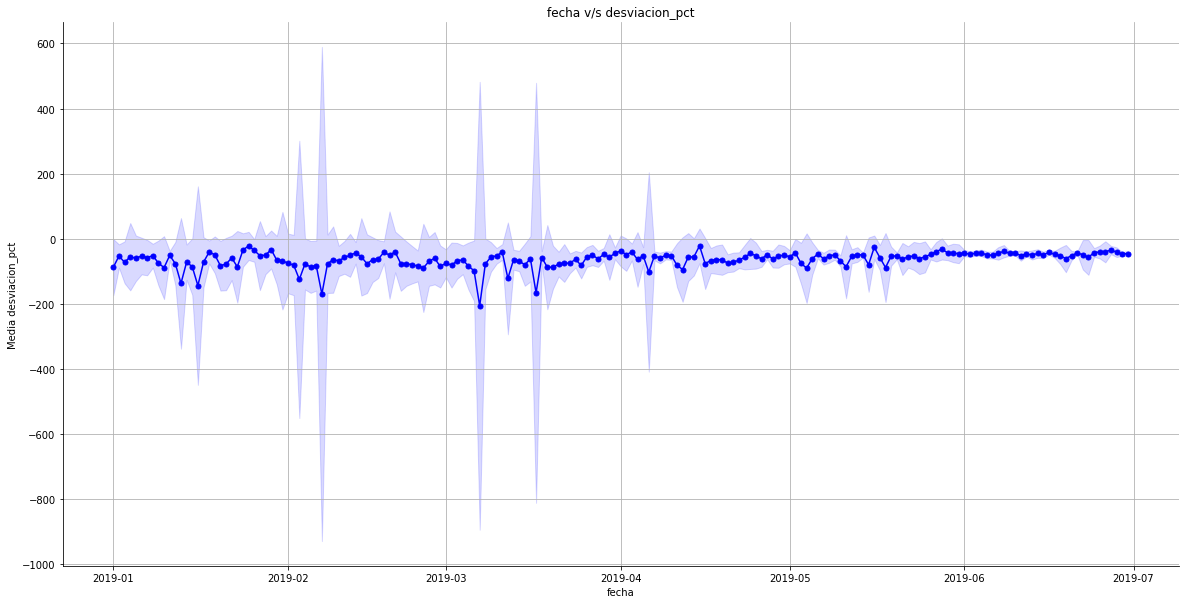

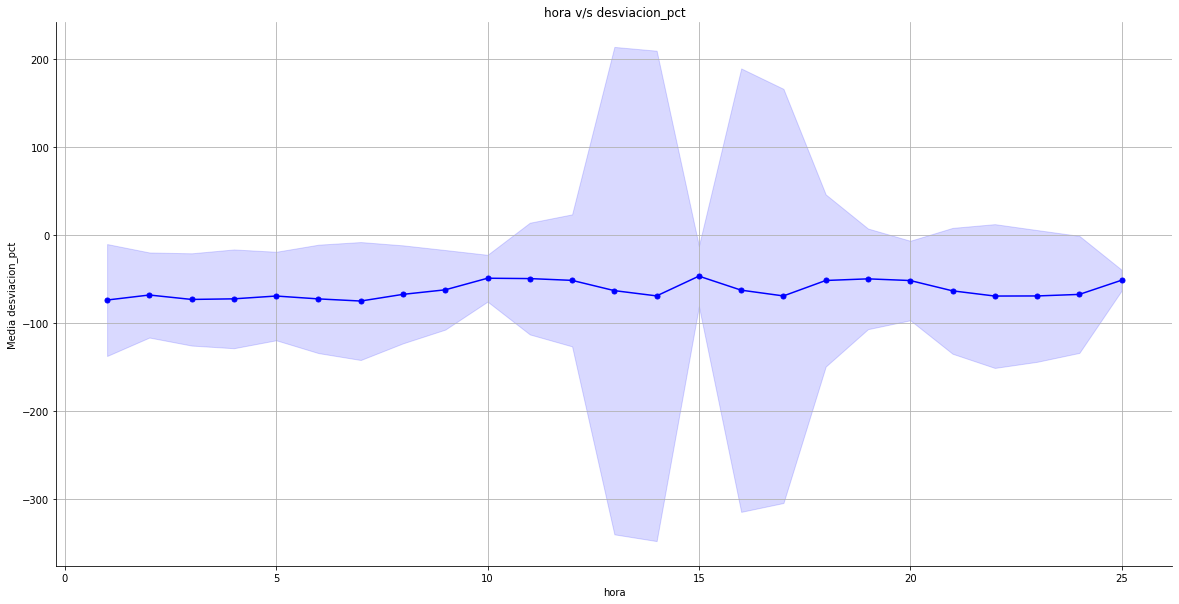

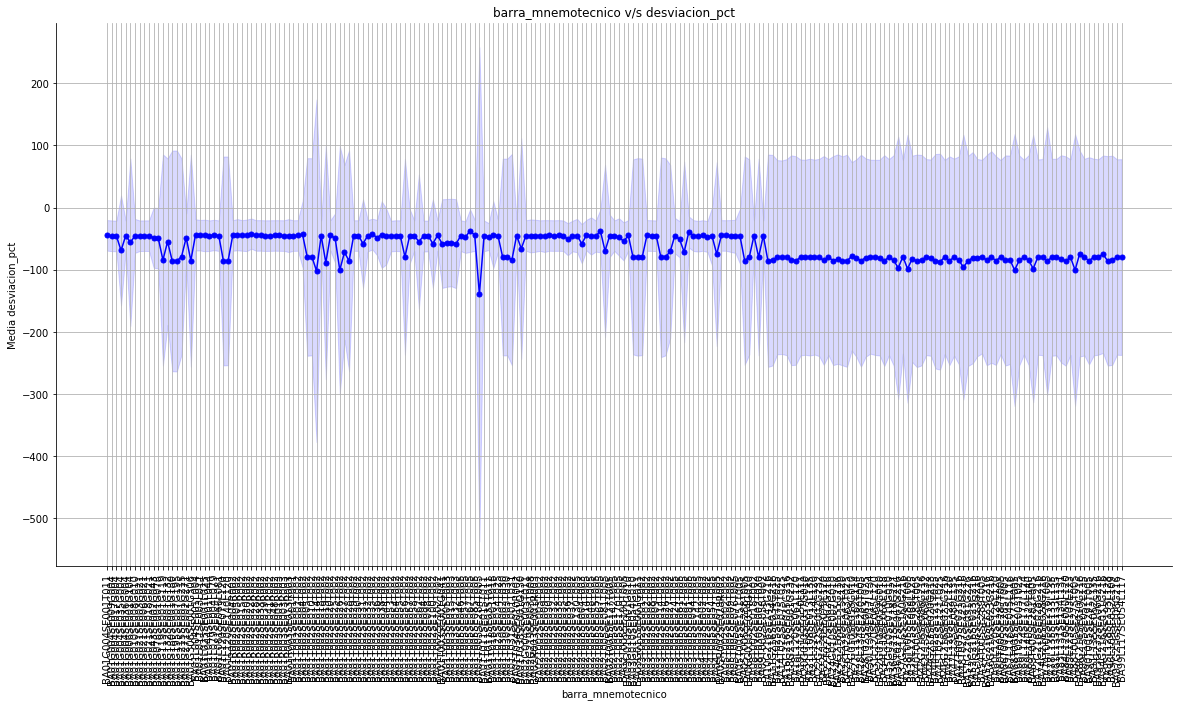

In [12]:
# Quitamos los valores inf para hacer los gráficos
costo_marginal_plt = costo_marginal[costo_marginal.costo_real!=0]

plot_mean_std(costo_marginal_plt ,"fecha","desviacion_pct")
plot_mean_std(costo_marginal_plt,"hora","desviacion_pct")
plot_mean_std(costo_marginal_plt,"barra_mnemotecnico","desviacion_pct")

# 3. Visualización de datos
## Barra con costo 0
Para calcular la barra con costo real 0 durante todos los días utilizaremos que los costos reales son siempre positivos, como lo vimos en la sección anterior. 

In [13]:
df_aux = costo_marginal.groupby(['barra_mnemotecnico'])[["costo_real"]].apply(lambda x: x.mean()).reset_index()
print("La barra con costo 0 durante todos los dias es:")
df_aux[df_aux.costo_real == 0]

La barra con costo 0 durante todos los dias es:


,barra_mnemotecnico,costo_real
11,BA01G049SE001G049,0.0


Podemos corroborar esto con el gráfico de los costos de la barra:

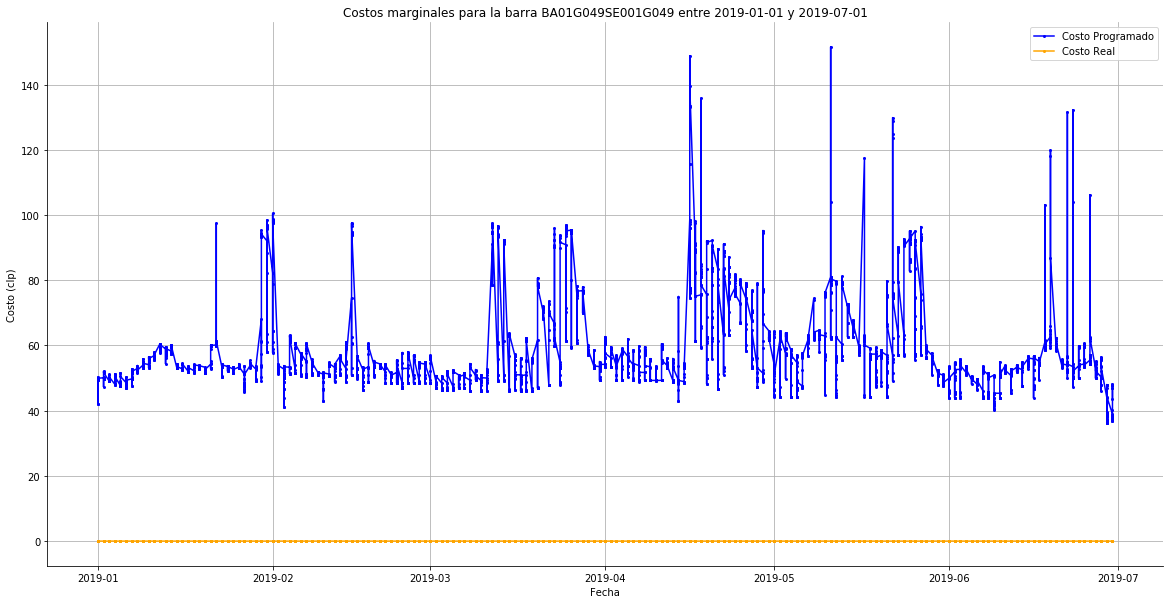

In [14]:
time_plot_costo_barra("BA01G049SE001G049", "2019-01-01", "2019-07-01")

In [15]:
# quitamos la barra de los costos
costo_marginal = costo_marginal[costo_marginal.barra_mnemotecnico != "BA01G049SE001G049"]

## Gráficamos algunas barras

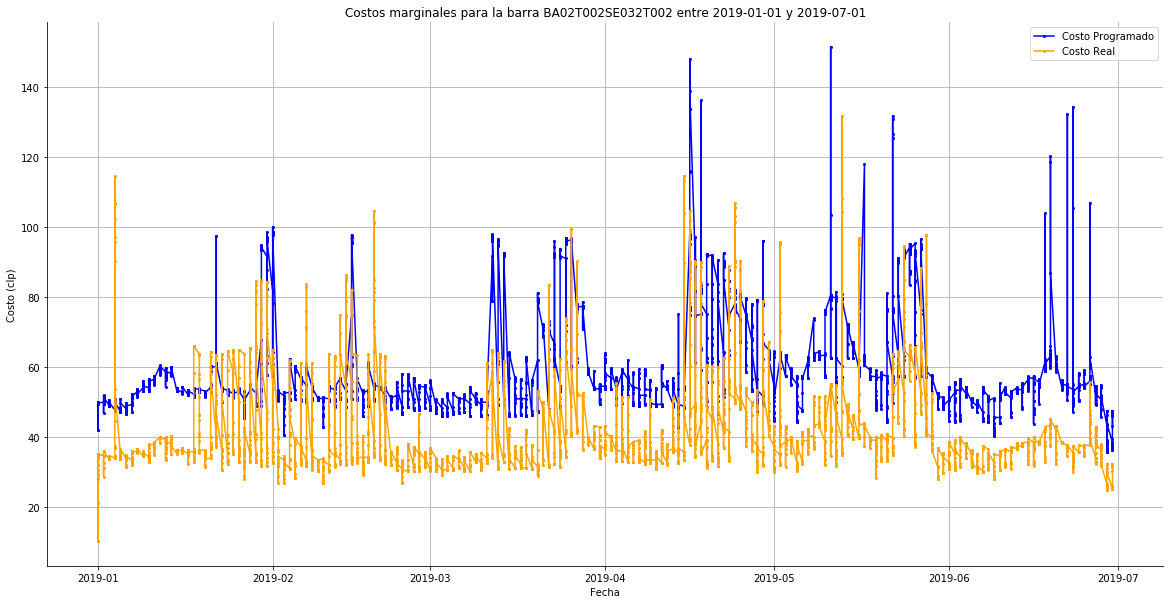

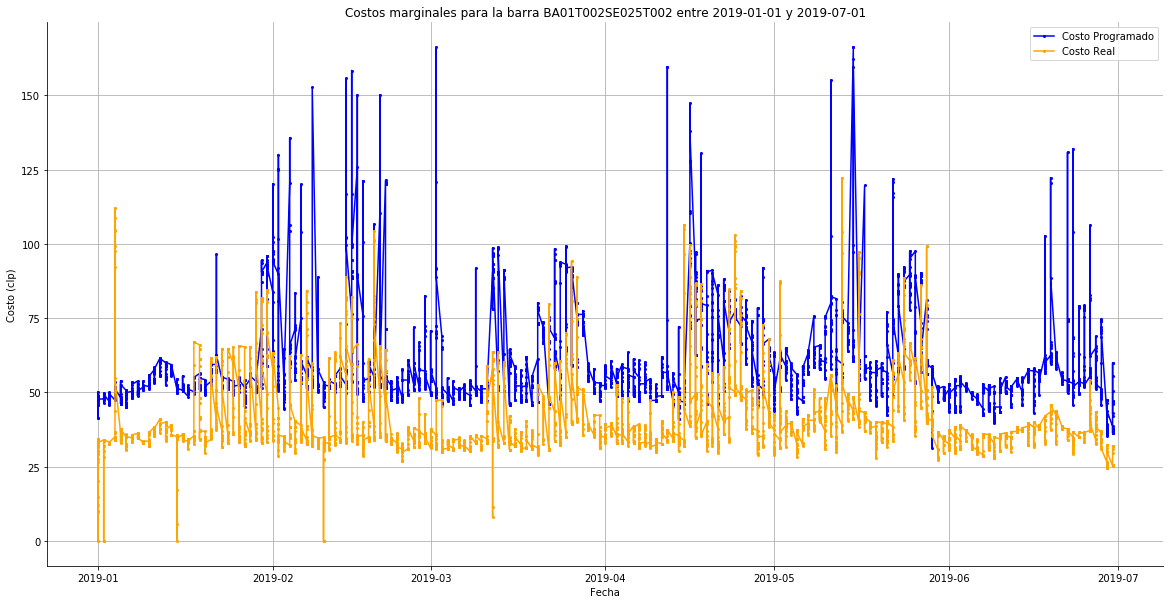

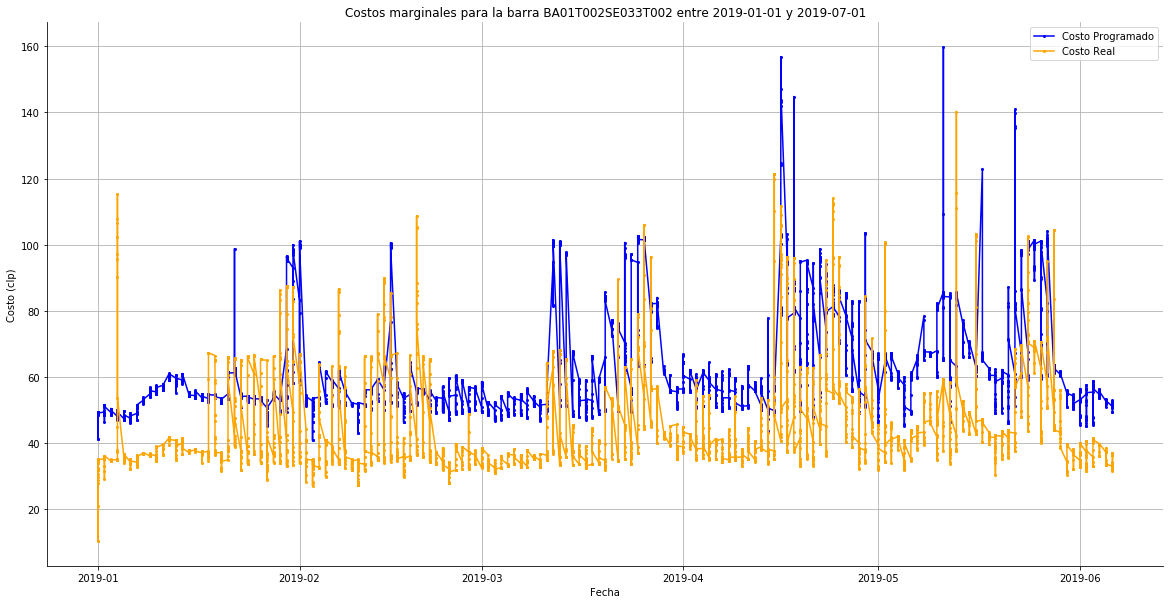

In [16]:
time_plot_costo_barra("BA02T002SE032T002", "2019-01-01", "2019-07-01")
time_plot_costo_barra("BA01T002SE025T002", "2019-01-01", "2019-07-01")
time_plot_costo_barra("BA01T002SE033T002", "2019-01-01", "2019-07-01")

## Conclusiones más importantes
1. La media del costo programado es más alto que el costo real
2. Todas las horas del dia tienen la misma cantidad de observaciones, 38049, salvo  la hora 25, con 212 observaciones
3. El 21.4 % de las barras con costo real tiene un costo programado
3. La mayoría de las observaciones del costo real están bajo 40 
4. La mayoría de las observaciones del costo programado están sobre 50 
5. El 96% de costos programados que se desvian más de un 15% del costo real.
6. Se pueden observar ciclos semanales y ciclos diarios que tienen su peak entre la hora 20 y 25.


## 4. Base para los modelos
A continuación cargamos la base de predicción y creamos nuevas características 

In [17]:
prediccion = pd.read_csv("../data/base_para_prediccion.csv")

prediccion.fecha = pd.to_datetime(prediccion.fecha).dt.tz_convert(None) 
# botamos los duplicados
prediccion.drop_duplicates(subset = ["nemotecnico_se","fecha","hora"], inplace = True)

prediccion.fillna(0,inplace=True)



prediccion["año"] = prediccion.fecha.map(lambda x: x.year)
prediccion["mes"] = prediccion.fecha.map(lambda x: x.month)
prediccion["dia_calendario"] = prediccion.fecha.map(lambda x: x.day)
prediccion["dia_semana"] = prediccion.fecha.map(lambda x: x.dayofweek)
prediccion["dummy_fin_semana"] = prediccion.dia_semana.map(lambda x: 1 if x in [5,6] else 0)


prediccion.head()


,nemotecnico_se,fecha,hora,gen_eolica_total_mwh,gen_geotermica_total_mwh,gen_hidraulica_total_mwh,gen_solar_total_mwh,gen_termica_total_mwh,cmg_real,cmg_prog,cmg_desv,cmg_desv_pct,n_barras,demanda_mwh,cap_inst_mw,año,mes,dia_calendario,dia_semana,dummy_fin_semana
0,SE031G216,2019-01-04,1,0.0,0.0,0.0,0.0,0.0,56.2,55.627852,0.57,1.02,2,1210767,13.20785,2019,1,4,4,0
1,SE031G216,2019-01-04,2,0.0,0.0,0.0,0.0,0.0,56.2,55.376645,0.82,1.48,2,113232,13.20785,2019,1,4,4,0
2,SE031G216,2019-01-04,3,0.0,0.0,0.0,0.0,0.0,56.2,59.531891,-3.33,-5.59,2,1089415,13.20785,2019,1,4,4,0
3,SE031G216,2019-01-04,4,0.0,0.0,0.0,0.0,0.0,56.2,174.378923,-118.18,-67.77,2,1096867,13.20785,2019,1,4,4,0
4,SE031G216,2019-01-04,5,0.0,0.0,0.0,0.0,0.0,56.2,172.820310,-116.62,-67.48,2,1071851,13.20785,2019,1,4,4,0


In [18]:
print(prediccion.dtypes)

nemotecnico_se                      object
fecha                       datetime64[ns]
hora                                 int64
gen_eolica_total_mwh               float64
gen_geotermica_total_mwh           float64
gen_hidraulica_total_mwh           float64
gen_solar_total_mwh                float64
gen_termica_total_mwh              float64
cmg_real                           float64
cmg_prog                           float64
cmg_desv                           float64
cmg_desv_pct                       float64
n_barras                             int64
demanda_mwh                          int64
cap_inst_mw                        float64
año                                  int64
mes                                  int64
dia_calendario                       int64
dia_semana                           int64
dummy_fin_semana                     int64
dtype: object


In [19]:
print("La fecha mínima de observaciones es :" ,prediccion.fecha.min())
print("La fecha mínima de observaciones es :" ,prediccion.fecha.max())
print("Mínimo nro de barras:",prediccion.n_barras.min())
print("Máximo nro de barras:",prediccion.n_barras.max())
print("La bases tienen el siguiente número de columnas: ",prediccion.shape[0])
print("Numero de subestaciones que aparecen en la base: ",prediccion.nemotecnico_se.nunique())


La fecha mínima de observaciones es : 2019-01-01 00:00:00
La fecha mínima de observaciones es : 2019-06-30 00:00:00
Mínimo nro de barras: 1
Máximo nro de barras: 6
La bases tienen el siguiente número de columnas:  112779
Numero de subestaciones que aparecen en la base:  29


In [20]:
# Distribución de las subestaciones por número de barras
prediccion.groupby(["nemotecnico_se"]).agg({"n_barras":"mean"}).reset_index().n_barras.value_counts()/29*100

2    31.034483
1    31.034483
3    24.137931
4     6.896552
6     3.448276
5     3.448276
Name: n_barras, dtype: float64

In [21]:
prediccion.describe()

,hora,gen_eolica_total_mwh,gen_geotermica_total_mwh,gen_hidraulica_total_mwh,gen_solar_total_mwh,gen_termica_total_mwh,cmg_real,cmg_prog,cmg_desv,cmg_desv_pct,n_barras,demanda_mwh,cap_inst_mw,año,mes,dia_calendario,dia_semana,dummy_fin_semana
count,112779.000000,112779.0,112779.0,112779.000000,112779.000000,112779.000000,112779.000000,112779.000000,112779.000000,112779.00,112779.000000,1.127790e+05,112779.000000,112779.0,112779.000000,112779.000000,112779.000000,112779.00000
mean,12.502993,0.0,0.0,11.554420,1.396042,22.261194,61.170058,62.215400,-1.045338,inf,2.331844,6.357056e+07,128.719565,2019.0,3.512675,15.557098,3.011545,0.28625
std,6.924090,0.0,0.0,42.252585,8.065506,77.541347,25.414147,25.307759,24.711575,NaN,1.304096,3.948683e+08,167.948649,0.0,1.690061,8.750816,1.991979,0.45201
min,1.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,-1.713131,-562.470000,-3403.97,1.000000,-9.821095e+09,2.989800,2019.0,1.000000,1.000000,0.000000,0.00000
25%,7.000000,0.0,0.0,0.000000,0.000000,0.000000,49.130000,49.906745,-3.790000,-7.07,1.000000,7.464800e+05,18.420000,2019.0,2.000000,8.000000,1.000000,0.00000
50%,13.000000,0.0,0.0,0.000000,0.000000,0.000000,54.610000,55.420601,-0.310000,-0.58,2.000000,4.507282e+06,51.850000,2019.0,4.000000,16.000000,3.000000,0.00000
75%,19.000000,0.0,0.0,0.102675,0.000000,1.525000,63.500000,64.701951,1.670000,2.92,3.000000,1.332345e+07,184.685500,2019.0,5.000000,23.000000,5.000000,1.00000
max,25.000000,0.0,0.0,472.000000,86.050000,570.600800,240.360000,610.600000,175.020000,inf,6.000000,1.004240e+10,597.782800,2019.0,6.000000,31.000000,6.000000,1.00000


En conclusión:
1. Hay una variable categórica que es el nombre de la subestación y la fecha de la observación
2. La base para la predicción tiene 112779 para 29 subestaciones 
3. Las estaciones tienes de 1 a 6 barras y el 66% tiene menos de 3 barras
4. Las series de generacón eolica y geotérmica no tienen datos
5. Los costos marginales reales y programados son bastante similares

## Gráficos por estación
Conclusiones más importante:
1. Para los gráficos de generación solar obeservamos que hay un ciclo que se ajusta a la hos horas de sol, es decir, hay generación térmica por generación solar solo cuando hay luz de día
2. Para los gráficos de generación térmica, vemos que hay peaks cerca de las 15 y 20 horas, aunque es dificil notar cierta estacionalidad

### Generación solar 

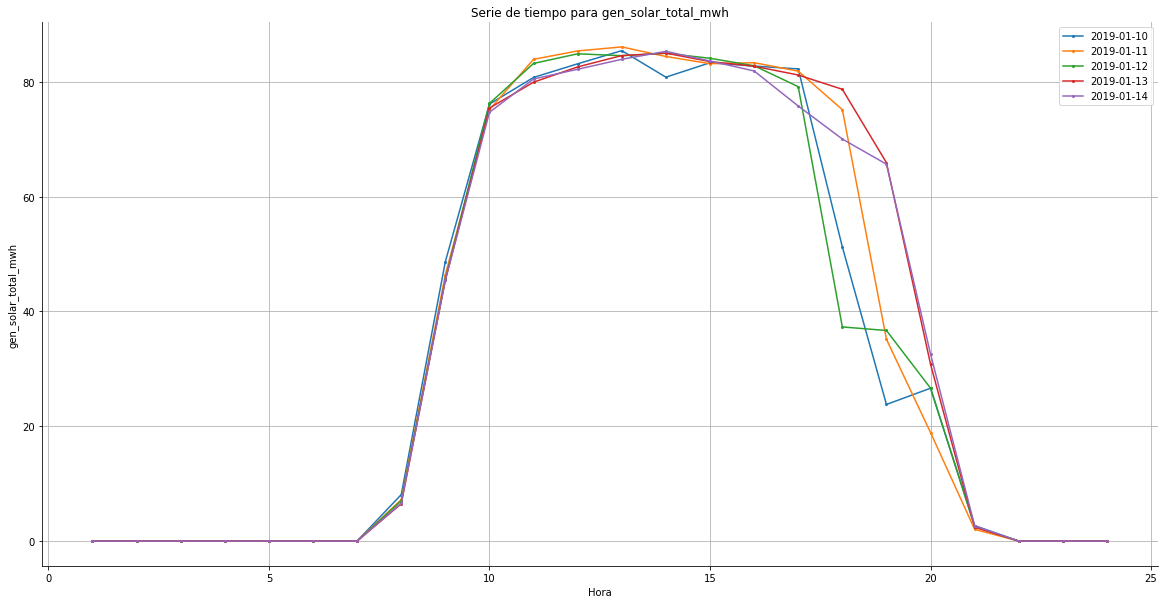

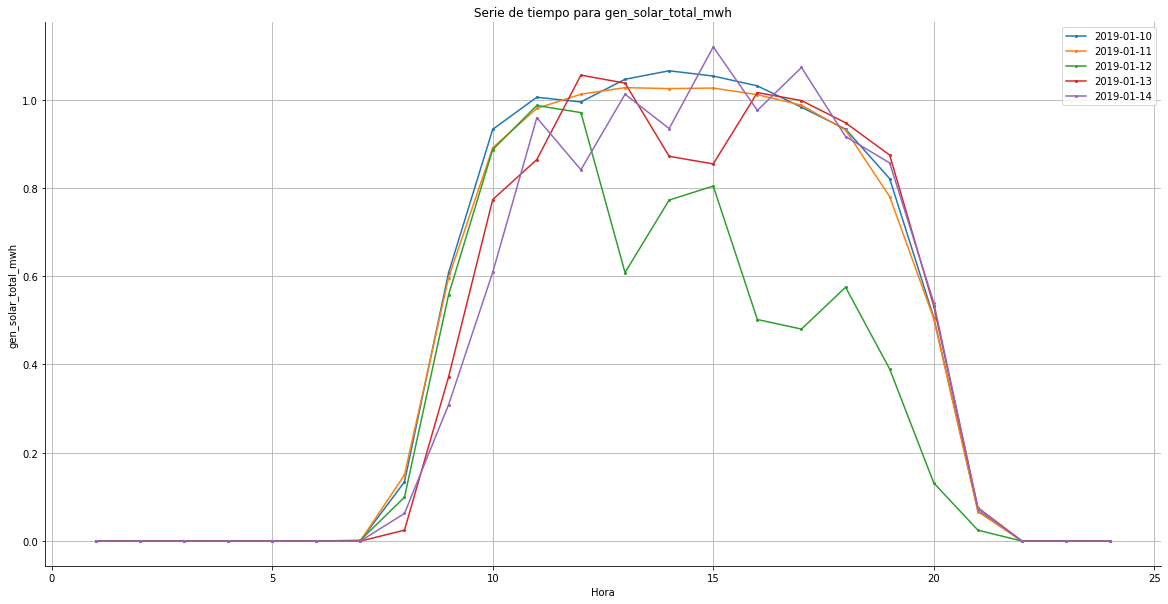

In [22]:
subestacion = 'SE005T002'
var_y = 'gen_solar_total_mwh'
fechas = ['2019-01-10', '2019-01-11','2019-01-12','2019-01-13','2019-01-14']
time_plot_prediccion(subestacion, var_y, fechas)


subestacion = 'SE127T005'
fechas = ['2019-01-10', '2019-01-11','2019-01-12','2019-01-13','2019-01-14']
time_plot_prediccion(subestacion, var_y, fechas)

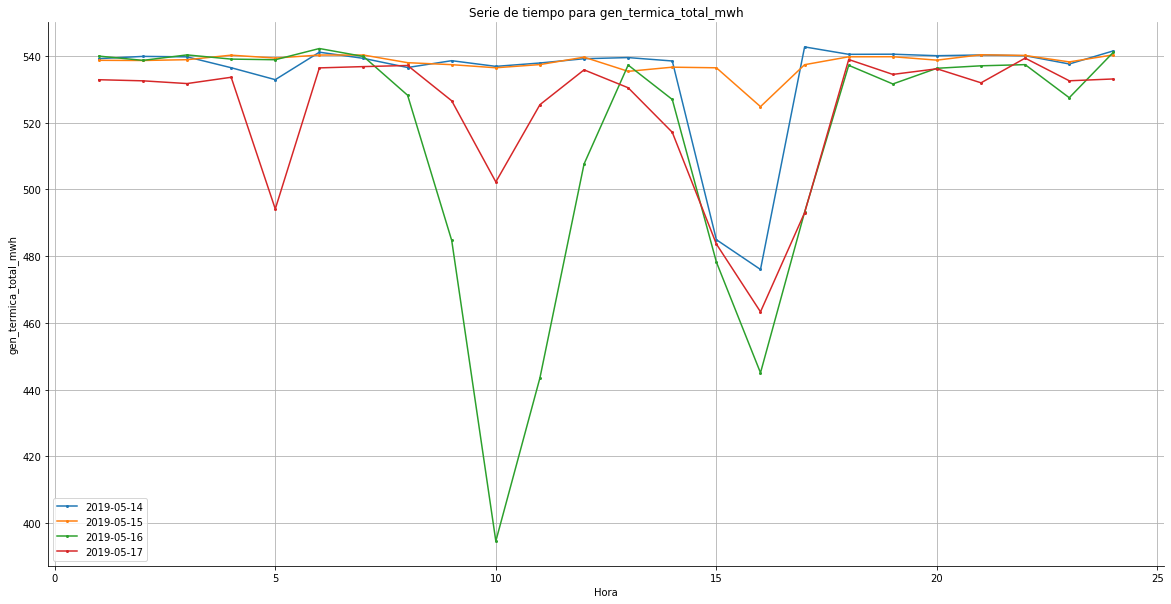

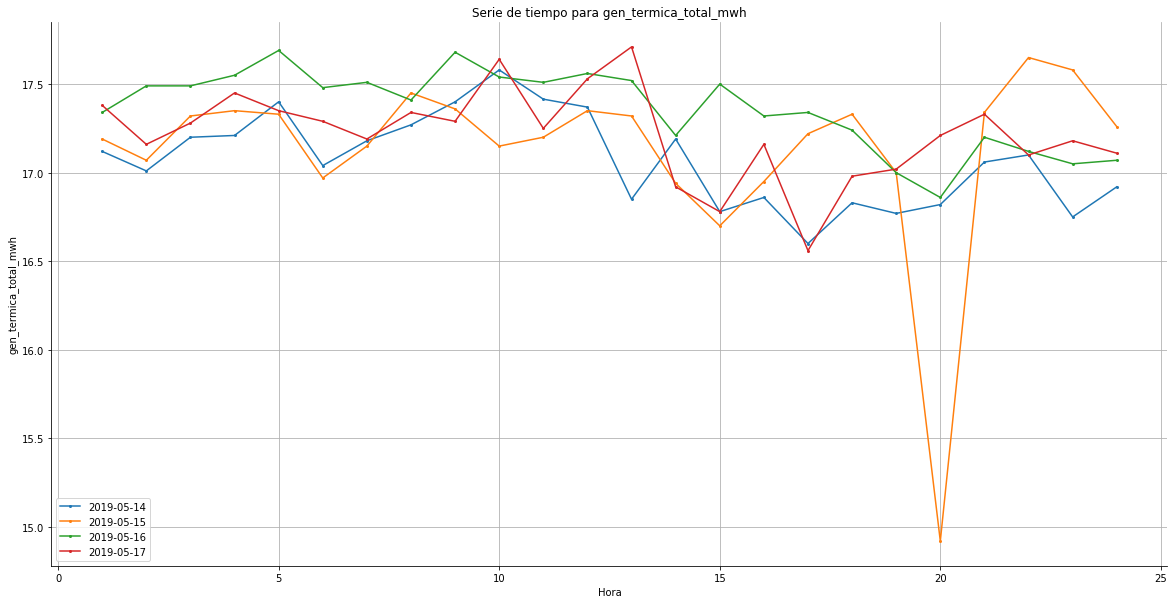

In [23]:
subestacion = 'SE020G213'
var_y = 'gen_termica_total_mwh'
fechas = ['2019-05-14', '2019-05-15','2019-05-16','2019-05-17']
time_plot_prediccion(subestacion, var_y, fechas)

subestacion = 'SE106G216'
time_plot_prediccion(subestacion, var_y, fechas)

# 5. Predicción de desviaciones del costo marginal: modelo 1
Creamos la variable categórica para la desviación y vemos que hay un 75% de datos que no se desvía 

In [24]:
# dummy de desviación 
prediccion["desviacion_cat"] = prediccion.cmg_desv_pct.map(lambda x: 1 if abs(x)>15 else 0)
print(prediccion.desviacion_cat.value_counts()/prediccion.desviacion_cat.value_counts().sum()*100)

0    74.737318
1    25.262682
Name: desviacion_cat, dtype: float64


In [25]:
# Suma de series 
prediccion["en_total_mwh"] = prediccion.gen_eolica_total_mwh+\
            prediccion.gen_geotermica_total_mwh+prediccion.gen_hidraulica_total_mwh+\
            prediccion.gen_solar_total_mwh+prediccion.gen_termica_total_mwh

Para la creación de lags y promedios moviles consideramos los siguientes créditos:

1.Promedios moviles:

    Consideramos los promedios, desviación estandar, máximos y mínimos con ventanas de medio día, un día y una semana.
    Lo anterior para capturar los efectos cíclicos que vimos en la primera 1-3 de este notebook.
2.Lags

    Consideraremos el resultado de si es que hay desface o nó las 12 horas anteriores

In [26]:
## Ordenamos por fecha y hora para hacer los shifts
prediccion.sort_values(by = ["nemotecnico_se","fecha","hora"],inplace=True)

### valores moviles
# ventana medio dia (12), Diario(24) y semanal (168) 
columns = ["en_total_mwh","cmg_real","cmg_prog","cmg_desv","cmg_desv_pct",\
            "demanda_mwh","cap_inst_mw"]

for column in columns:
    for ventana in [12,24,168]:
        column_name = f"{column}_win{ventana}_"
        prediccion[column_name + "mean"] = prediccion.groupby(['nemotecnico_se'])[column].apply(lambda x: x.rolling(ventana).mean())
        prediccion[column_name + "std"] = prediccion.groupby(['nemotecnico_se'])[column].apply(lambda x: x.rolling(ventana).std())
        prediccion[column_name + "min"] = prediccion.groupby(['nemotecnico_se'])[column].apply(lambda x: x.rolling(ventana).min())
        prediccion[column_name + "max"] = prediccion.groupby(['nemotecnico_se'])[column].apply(lambda x: x.rolling(ventana).max())

        
###lags
columns = ["en_total_mwh","cmg_real","cmg_prog","cmg_desv","cmg_desv_pct",\
            "demanda_mwh","cap_inst_mw","desviacion_cat"]
for column in columns:
    for lag in range(1,13):
        prediccion[f"{column}_lag{lag}"] = prediccion.groupby(['nemotecnico_se'])[column].apply(lambda x: x.shift(lag))
         

Creamos la variable target haciendo un shift de la variable desviación para predecir si es que la proxima hora va a tener una desviación, y limpiamos el dataset de valores infinitos o nan

In [27]:
prediccion['target'] = prediccion.groupby(['nemotecnico_se'])['desviacion_cat'].apply(lambda x: x.shift(-1))
prediccion.replace([np.inf, -np.inf], np.nan,inplace = True)
prediccion.dropna(inplace = True)
prediccion.reset_index(drop = True,inplace = True)
prediccion.head()  

,nemotecnico_se,fecha,hora,gen_eolica_total_mwh,gen_geotermica_total_mwh,gen_hidraulica_total_mwh,gen_solar_total_mwh,gen_termica_total_mwh,cmg_real,cmg_prog,...,desviacion_cat_lag4,desviacion_cat_lag5,desviacion_cat_lag6,desviacion_cat_lag7,desviacion_cat_lag8,desviacion_cat_lag9,desviacion_cat_lag10,desviacion_cat_lag11,desviacion_cat_lag12,target
0,SE001T002,2019-01-07,24,0.0,0.0,0.0,0.0,0.0,52.41,88.387739,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,SE001T002,2019-01-08,1,0.0,0.0,0.0,0.0,0.0,53.75,56.965158,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,SE001T002,2019-01-08,2,0.0,0.0,0.0,0.0,0.0,53.75,54.724744,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,SE001T002,2019-01-08,3,0.0,0.0,0.0,0.0,0.0,53.75,52.655862,...,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,SE001T002,2019-01-08,4,0.0,0.0,0.0,0.0,0.0,53.75,52.547490,...,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Preparación de las matrices para la clasificación
Para la construcción de las matrices para la clasificación
vamos a balancear las clases haciendo un undersampling, es decir vamos quitar filas
de la clase que tiene más. 
Esto también nos va a ayudar a que los cálculos sean computacionalmente menos pesados.

In [28]:
count_class_0, count_class_1 = prediccion.target.value_counts()
print("Base original:")
print("clase 1:",count_class_0)
print("clase 0:",count_class_1)
# Divide by class
df_class_0 = prediccion[prediccion['target'] == 0]
df_class_1 = prediccion[prediccion['target'] == 1]

df_class_0_under = df_class_0.sample(count_class_1)

prediccion_us = pd.concat([df_class_0_under, df_class_1], axis=0)

print("Sample balanceado:")
prediccion_us.target.value_counts()


Base original:
clase 1: 80515
clase 0: 27440
Sample balanceado:


1.0    27440
0.0    27440
Name: target, dtype: int64

A continuacion crearemos 2 matrices de características X (una con todas las variables y otra con las 
variables que tienen un 70% más de importancia*) y la el vector target y. Además, dividiremos estas matrices en las
de entrenamiento y validación.

En la matriz de características consideraremos todos los lags y promedios moviles ademas de los costos y también
la generacion de energía total en_total_mwh. Consideraremos el número de barras como medida de tamaños.
Sin embargo, no consideraremos las variables de generación de energia por separado.

*Crearemos la matriz con menos variables para hacer un gridsearch para buscar los mejores parámetros para el modelo

In [29]:
# Construcción del tablon con variables y target
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.tree import DecisionTreeClassifier


quitar = ["target","fecha","gen_eolica_total_mwh","gen_geotermica_total_mwh",\
           "gen_hidraulica_total_mwh","gen_solar_total_mwh","gen_termica_total_mwh"]

## Creamos la matriz quitando todas las columnas que no usaremos 
X = prediccion_us[list(set(prediccion.columns)-set(quitar))]

#transformamos los nombres de las subestaciones a numeros
X["nemotecnico_se"] = preprocessing.LabelEncoder().fit_transform(X["nemotecnico_se"])

# Creamos los dataframes 
X = pd.DataFrame(X ,columns = X.columns)
y = prediccion_us[["target"]]


# Hacemos el split para separar entre bases de entrenamiento y evaluación
X_train, X_test,  y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)


# Entrenamos un clasificador de regressión para ver que variables tienen más información
model_dt = DecisionTreeClassifier()
model_dt.fit(X_train,y_train)
importance = model_dt.feature_importances_

importancia = pd.DataFrame(zip(X.columns,importance),columns =["variables","peso"])
importancia.sort_values(by="peso", ascending = False,inplace= True)
importancia["suma_acumulada"] = importancia.peso.cumsum()

print("Total de variables:",importancia.shape[0])
print("Nro Variables que acumulan el 70% de importancia:",importancia[importancia.suma_acumulada < 0.70].shape[0])
variables = importancia[importancia.suma_acumulada < 0.70].variables.tolist()

/Users/benjaminobando/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  from ipykernel import kernelapp as app


Total de variables: 196
Nro Variables que acumulan el 70% de importancia: 25


In [30]:
importancia["peso_norm"] = importancia["peso"]/importancia["peso"].max() 
importancia[0:20]

,variables,peso,suma_acumulada,peso_norm
157,desviacion_cat,0.454580,0.454580,1.000000
9,cmg_desv,0.031702,0.486282,0.069739
75,cmg_prog_win24_std,0.031344,0.517626,0.068952
154,hora,0.022422,0.540048,0.049324
51,cmg_desv_pct_win168_std,0.012045,0.552093,0.026496
50,cmg_prog,0.011017,0.563110,0.024236
163,cmg_desv_pct_win12_std,0.010048,0.573158,0.022104
23,cmg_desv_pct,0.009718,0.582876,0.021378
120,cmg_real_win12_std,0.008736,0.591612,0.019218
56,cmg_desv_pct_win24_std,0.008662,0.600274,0.019055


Para finalizar llevamos todo a una escala [0,1] en base a la matriz de entrenamiento

In [31]:
scaler = MinMaxScaler()

scaler.fit(X_train)
X_train = pd.DataFrame(scaler.transform(X_train) ,columns = X_train.columns)
X_train_model_check = X_train[variables]
X_test = pd.DataFrame(scaler.transform(X_test) ,columns = X_test.columns)

A continuación buscaremos los mejores parámetros para entrenar una regresión logística. 
El motivo de utilizar una regresión logistica es por que es el clasificador estandar. Para buscar los mejores parametros utilizaremos el data set que acumula el 70% de la info. Esto para que el cálculo sea menos pesado

In [32]:
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression

model = LogisticRegression()

# GridSearch para la regresión logísitica
cv = RepeatedStratifiedKFold(n_splits=2, n_repeats=2, random_state=1)

space = dict()
space['solver'] = ['newton-cg', 'lbfgs', 'liblinear']
space['penalty'] = ['none', 'l1', 'l2', 'elasticnet']
space['C'] = [1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1, 10, 100]

search = GridSearchCV(model, space, scoring="recall_weighted", n_jobs=-1, cv=cv)

result = search.fit(X_train_model_check, y_train)

print('Mejor score: %s' % result.best_score_)
print('Mejores parámetros: %s' % result.best_params_)

Mejor score: 0.8328040399833403
Mejores parámetros: {'C': 1e-05, 'penalty': 'l2', 'solver': 'newton-cg'}


/Users/benjaminobando/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Con los parámetros anteriores, entrenamos una regresión logística con la matriz completa y calcularemos las estadísticas principales en problemas de clasificación

/Users/benjaminobando/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:1505: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio "
/Users/benjaminobando/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/benjaminobando/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.

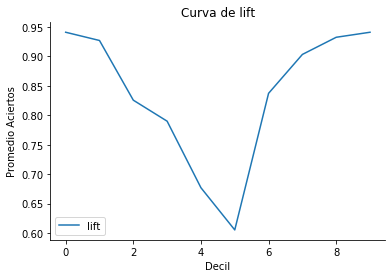

              precision    recall  f1-score   support

      desvio       0.80      0.90      0.85      8211
   no_desvio       0.88      0.78      0.83      8253

    accuracy                           0.84     16464
   macro avg       0.84      0.84      0.84     16464
weighted avg       0.84      0.84      0.84     16464



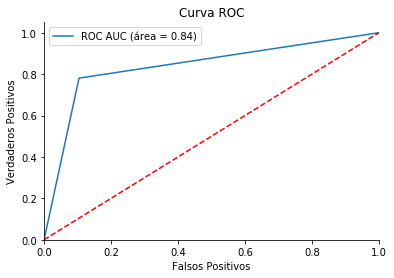

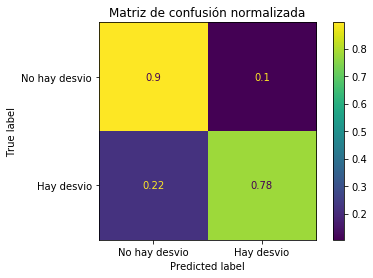

In [33]:
lr_clf1 = LogisticRegression(C= 1e-05, penalty = 'none', solver='lbfgs')
lr_clf1.fit(X_train,y_train)
y_pred =lr_clf1.predict(X_test)
y_pred_prob = [x[1] for x in lr_clf1.predict_proba(X_test)]
plot_classification_analysis(lr_clf1,X_test,y_test,y_pred,y_pred_prob)

In [34]:
# Calculamos la importancia de las características de acuerdo al peso de las variables
importancia_modelo = pd.DataFrame(lr_clf1.coef_.transpose(),columns =["peso"])
importancia_modelo["nombre"] = X_train.columns

importancia_modelo["peso_norm"] = abs(importancia_modelo["peso"]/importancia_modelo["peso"].sum())
importancia_modelo.sort_values(by="peso_norm",ascending = False,inplace= True)
importancia_modelo[0:10]

,peso,nombre,peso_norm
20,4.647982,cmg_real,8.647600
157,2.843055,desviacion_cat,5.289521
57,-2.043698,cmg_prog_lag3,3.802313
75,1.989084,cmg_prog_win24_std,3.700704
60,1.890892,cmg_real_win24_max,3.518017
14,-1.878669,cmg_real_lag1,3.495276
100,-1.827325,cmg_real_lag2,3.399750
148,-1.746933,cmg_prog_lag12,3.250179
80,-1.742374,cmg_desv_win24_max,3.241699
105,-1.621685,cmg_prog_lag10,3.017156


Análisis de las metricas:
1. Check de sanidad - Curva de lift:<br>
La curva de lift es la tasa de acierto en la clasificación ordenado por decil de probabilidad. Es decir, ordeno de menor a mayor en términos de la probabilidad de clasificación y hago diez grupos del mismo tamaño. Después, calculo cuantas observaciones clasifique bien en cada uno de los deciles (promedio de aciertos). Un buen modelo debería tener una curva de lift en forma de U, ya que los deciles más bajos tienen probabilidad cercana a 0 de ser clasificados como 1 y los deciles más altos tienen probabilidad cercana a 1 de ser clasificados como 1. En nuestro caso, la curva de lift del modelo es una U por lo que concluimos que nuestro modelo está clasificanco bien.
2. Con respecto a las metricas 
    1. Con respecto a las métricas de precisión y recall, no hay ninguna que domine a la otra y son bastante elevadas. 
    2. De ambas métricas, destacamos el recall que nos dice que de nuestras predicciones cuantas están predichas en la clase correcta. Que el recall este al mismo nivel y alto (por sobre 0.78) nos da nociones que nuestro modelo puede predecir bien tanto los fenomenos de desvío como los que no lo que también podemos observar en la curva de lift.
    3. Lo anteior tambien se logro al balancear las clases, ya que si no hubieramos realizado este procedimiento, probablemente el recall seria mucho más alto en la clase más masiva que en la otra.
3. Con respecto a la importancia de las características
    1. Si lo vemos a nivel de coeficientes de la regresión logística vemos que el costo marginal real es la variable más importantes y ademas  influye positivamente, es decir a mayor costo marginal real mayor es la probabilidad de caer en desviación.
    2. La segunda variable más importante es la desviación estandar de la ventana de 24hrs del costo programado 
lo que puede tener relación con la estacionalidad del proceso. Y tambien influye postivamente en la predicción. 
    3. De lo anterior podriamos deducir de que es probable que en los valores más altos de costos me tiendo a equivocar más
    4. En tercer lugar y con impacto negativo está el lag de 10 horas del costo programado. 

## 6. Predicción de desviaciones del costo marginal: modelo 2

Existen diversas soluciones en el caso que nos envien los datos con acualizaciones cada 12 horas. La más simple es entrenar 12 modelos, con targets con desfase de 1,2,3,.. y 12 horas.
<br>
Para validar este ejemplo vamos a entrenar un modelo con un que intenta predecir la 6ta hora siguiente. Por ejemplo, si son las 12:00 vamos a entrenar un modelo donde el taget es el desvio a las 18:00.

<br>
Para lo anterior modificaremos el tablón de variables 

In [35]:
prediccion['target'] = prediccion.groupby(['nemotecnico_se'])['desviacion_cat'].apply(lambda x: x.shift(-6))
prediccion.replace([np.inf, -np.inf], np.nan,inplace = True)
prediccion.dropna(inplace = True)
prediccion.reset_index(drop = True,inplace = True)

prediccion.head()  

,nemotecnico_se,fecha,hora,gen_eolica_total_mwh,gen_geotermica_total_mwh,gen_hidraulica_total_mwh,gen_solar_total_mwh,gen_termica_total_mwh,cmg_real,cmg_prog,...,desviacion_cat_lag4,desviacion_cat_lag5,desviacion_cat_lag6,desviacion_cat_lag7,desviacion_cat_lag8,desviacion_cat_lag9,desviacion_cat_lag10,desviacion_cat_lag11,desviacion_cat_lag12,target
0,SE001T002,2019-01-07,24,0.0,0.0,0.0,0.0,0.0,52.41,88.387739,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,SE001T002,2019-01-08,1,0.0,0.0,0.0,0.0,0.0,53.75,56.965158,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,SE001T002,2019-01-08,2,0.0,0.0,0.0,0.0,0.0,53.75,54.724744,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,SE001T002,2019-01-08,3,0.0,0.0,0.0,0.0,0.0,53.75,52.655862,...,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,SE001T002,2019-01-08,4,0.0,0.0,0.0,0.0,0.0,53.75,52.547490,...,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


A continuación realizamos el mismo proceso que en el modelo anterior. En este caso, por simplicidad, también entrenaremos utilizando una regresión logística

In [36]:
####### Balanceamos las clases 
count_class_0, count_class_1 = prediccion.target.value_counts()
print("Base original:")
print("clase 1:",count_class_0)
print("clase 0:",count_class_1)
# Divide by class
df_class_0 = prediccion[prediccion['target'] == 0]
df_class_1 = prediccion[prediccion['target'] == 1]

df_class_0_under = df_class_0.sample(count_class_1)

prediccion_us = pd.concat([df_class_0_under, df_class_1], axis=0)

print("Sample balanceado:")
print(prediccion_us.target.value_counts())

###########Creamos la matriz de características

quitar = ["target","fecha","gen_eolica_total_mwh","gen_geotermica_total_mwh",\
           "gen_hidraulica_total_mwh","gen_solar_total_mwh","gen_termica_total_mwh"]

## Creamos la matriz quitando todas las columnas que no usaremos 
X = prediccion_us[list(set(prediccion_us.columns)-set(quitar))]

#transformamos los nombres de las subestaciones a numeros
X["nemotecnico_se"] = preprocessing.LabelEncoder().fit_transform(X["nemotecnico_se"])

# Creamos los dataframes 
X = pd.DataFrame(X ,columns = X.columns)
y = prediccion_us[["target"]]


########### Hacemos el split para separar entre bases de entrenamiento y evaluación
X_train, X_test,  y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)


########## Entrenamos un clasificador de regressión para ver que variables tienen más información
model_dt = DecisionTreeClassifier()
model_dt.fit(X_train,y_train)
importance = model_dt.feature_importances_

importancia = pd.DataFrame(zip(X.columns,importance),columns =["variables","peso"])
importancia.sort_values(by="peso", ascending = False,inplace= True)
importancia["suma_acumulada"] = importancia.peso.cumsum()

print("Total de variables:",importancia.shape[0])
print("Nro Variables que acumulan el 70% de importancia:",importancia[importancia.suma_acumulada < 0.70].shape[0])
variables = importancia[importancia.suma_acumulada < 0.70].variables.tolist()



scaler = MinMaxScaler()

scaler.fit(X_train)
X_train = pd.DataFrame(scaler.transform(X_train) ,columns = X_train.columns)
####### Con las variables más importantes para hacer el gridsearch
X_train_model_check = X_train[variables]
X_test = pd.DataFrame(scaler.transform(X_test) ,columns = X_test.columns)



model = LogisticRegression()

# GridSearch para la regresión logísitica
cv = RepeatedStratifiedKFold(n_splits=2, n_repeats=2, random_state=1)

space = dict()
space['solver'] = ['newton-cg', 'lbfgs', 'liblinear']
space['penalty'] = ['none', 'l1', 'l2', 'elasticnet']
space['C'] = [1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1, 10, 100]

search = GridSearchCV(model, space, scoring="recall_weighted", n_jobs=-1, cv=cv)

result = search.fit(X_train_model_check, y_train)

print('Mejor score: %s' % result.best_score_)
print('Mejores parámetros: %s' % result.best_params_)

Base original:
clase 1: 80356
clase 0: 27437
Sample balanceado:
1.0    27437
0.0    27437
Name: target, dtype: int64


/Users/benjaminobando/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Total de variables: 196
Nro Variables que acumulan el 70% de importancia: 52


/Users/benjaminobando/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Mejor score: 0.6725026211787337
Mejores parámetros: {'C': 10, 'penalty': 'l1', 'solver': 'liblinear'}


/Users/benjaminobando/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:1505: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio "
/Users/benjaminobando/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/benjaminobando/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/optimize.py:212: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  "number of iterations.", ConvergenceWarning)


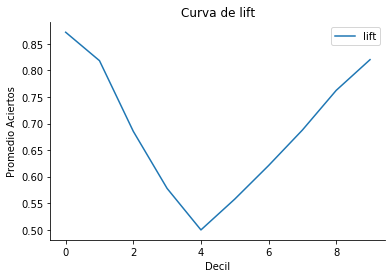

              precision    recall  f1-score   support

      desvio       0.68      0.70      0.69      8214
   no_desvio       0.70      0.68      0.69      8249

    accuracy                           0.69     16463
   macro avg       0.69      0.69      0.69     16463
weighted avg       0.69      0.69      0.69     16463



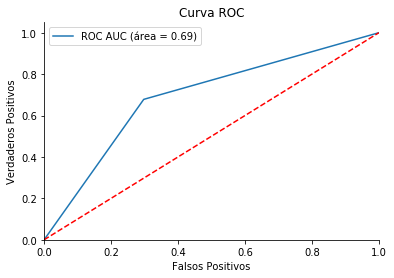

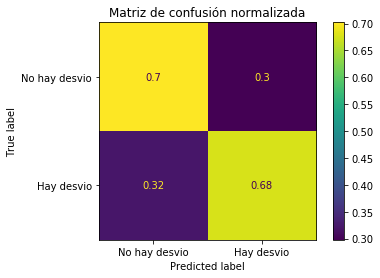

,peso,nombre,peso_norm
188,10.947346,cmg_desv_win12_min,3.182820
56,-6.544087,cmg_desv_pct_win24_std,1.902621
101,6.272596,cmg_prog_win168_max,1.823688
40,6.029552,cmg_desv_win168_min,1.753026
125,5.947454,demanda_mwh_win12_min,1.729157
10,5.822002,cmg_prog_win12_std,1.692683
39,5.648459,cmg_real_win12_max,1.642227
116,5.613532,demanda_mwh_win12_std,1.632073
163,4.737051,cmg_desv_pct_win12_std,1.377245
145,4.641532,cmg_desv_win12_std,1.349474


In [37]:
######### Entrenamos la regresión logística y calculamos las métricas
lr_clf1 = LogisticRegression(C= 1e-05, penalty = 'none', solver='newton-cg')
lr_clf1.fit(X_train,y_train)
y_pred =lr_clf1.predict(X_test)
y_pred_prob = [x[1] for x in lr_clf1.predict_proba(X_test)]
plot_classification_analysis(lr_clf1,X_test,y_test,y_pred,y_pred_prob)


######## Calculamos la importancia de las características de acuerdo al peso de las variables
importancia_modelo = pd.DataFrame(lr_clf1.coef_.transpose(),columns =["peso"])
importancia_modelo["nombre"] = X_train.columns

importancia_modelo["peso_norm"] = abs(importancia_modelo["peso"]/importancia_modelo["peso"].sum())
importancia_modelo.sort_values(by="peso_norm",ascending = False,inplace= True)
importancia_modelo[0:10]

Análisis de los resultados:
1. Métricas
    Con respecto al modelo anterior, mirando la curva de lift, el recall y la matriz de confusión, obsrevamos que el poder predictivo del modelo empeora. Sobre todo al clasificar los no desvíos.
    A diferencia del modelo anterior, las dos clases están más equiparadas en términos de la tasa de clasificación.
3. Con respecto a la importancia de las características
    1. A diferencia del modelo anterior las tres variables más importantes son positivas tienen coeficientes positivos
    2. La variable cmg_desv_win12_std que es la desviación estandar de la ventana de 12 horas de la desviación es la que tiene mayor poder predictivo
    3. En este modelo aparecen dentro de las 10 primeras variables las ventanas de las estadísticas descriptivas de las demandas
    
 En conclusión, vemos que el modelo perdio poder predictivo y que las variables relacionadas con la desviación tienen el mayor poder predictivo, en términos del tamaño de los coeficientes. 

# 7. Merge con datos de clima: modelo 3
Para esta parte realizamos un merge con la base de datos de clima.

In [38]:
clima = pd.read_csv("../data/datos_clima.csv")
clima.fecha = pd.to_datetime(clima.fecha).dt.tz_convert(None) 

clima.rename(columns={"subestacion":"nemotecnico_se"},inplace=True)

prediccion_clima = pd.merge(clima,prediccion,on =["nemotecnico_se","fecha"] )
prediccion_clima.head()

,fecha,nemotecnico_se,lat,lon,ALLSKY_SFC_SW_DWN,KT,PRECTOT,RH2M,T2M,T2MDEW,...,desviacion_cat_lag4,desviacion_cat_lag5,desviacion_cat_lag6,desviacion_cat_lag7,desviacion_cat_lag8,desviacion_cat_lag9,desviacion_cat_lag10,desviacion_cat_lag11,desviacion_cat_lag12,target
0,2019-05-06,SE019T002,-28.470641,-71.252694,2.0,0.31,0.0,74.66,16.39,11.94,...,1.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0
1,2019-05-06,SE019T002,-28.470641,-71.252694,2.0,0.31,0.0,74.66,16.39,11.94,...,1.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0
2,2019-05-06,SE019T002,-28.470641,-71.252694,2.0,0.31,0.0,74.66,16.39,11.94,...,1.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0
3,2019-05-06,SE019T002,-28.470641,-71.252694,2.0,0.31,0.0,74.66,16.39,11.94,...,0.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0
4,2019-05-06,SE019T002,-28.470641,-71.252694,2.0,0.31,0.0,74.66,16.39,11.94,...,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0


In [39]:
####### Balanceamos las clases 
count_class_0, count_class_1 = prediccion_clima.target.value_counts()
print("Base original:")
print("clase 1:",count_class_0)
print("clase 0:",count_class_1)
# Divide by class
df_class_0 = prediccion_clima[prediccion_clima['target'] == 0]
df_class_1 = prediccion_clima[prediccion_clima['target'] == 1]

df_class_0_under = df_class_0.sample(count_class_1)

prediccion_us = pd.concat([df_class_0_under, df_class_1], axis=0)

print("Sample balanceado:")
prediccion_us.target.value_counts()

###########Creamos la matriz de características

quitar = ["target","fecha","gen_eolica_total_mwh","gen_geotermica_total_mwh",\
           "gen_hidraulica_total_mwh","gen_solar_total_mwh","gen_termica_total_mwh"]

## Creamos la matriz quitando todas las columnas que no usaremos 
X = prediccion_us[list(set(prediccion_clima.columns)-set(quitar))]

#transformamos los nombres de las subestaciones a numeros
X["nemotecnico_se"] = preprocessing.LabelEncoder().fit_transform(X["nemotecnico_se"])

# Creamos los dataframes 
X = pd.DataFrame(X ,columns = X.columns)
y = prediccion_us[["target"]]


########### Hacemos el split para separar entre bases de entrenamiento y evaluación
X_train, X_test,  y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)



########## Entrenamos un clasificador de regressión para ver que variables tienen más información
model_dt = DecisionTreeClassifier()
model_dt.fit(X_train,y_train)
importance = model_dt.feature_importances_

importancia = pd.DataFrame(zip(X.columns,importance),columns =["variables","peso"])
importancia.sort_values(by="peso", ascending = False,inplace= True)
importancia["suma_acumulada"] = importancia.peso.cumsum()

print("Total de variables:",importancia.shape[0])
print("Nro Variables que acumulan el 70% de importancia:",importancia[importancia.suma_acumulada < 0.70].shape[0])
variables = importancia[importancia.suma_acumulada < 0.70].variables.tolist()



scaler = MinMaxScaler()

scaler.fit(X_train)
X_train = pd.DataFrame(scaler.transform(X_train) ,columns = X_train.columns)
####### Con las variables más importantes para hacer el gridsearch
X_train_model_check = X_train[variables]
X_test = pd.DataFrame(scaler.transform(X_test) ,columns = X_test.columns)



model = LogisticRegression()

# GridSearch para la regresión logísitica
cv = RepeatedStratifiedKFold(n_splits=2, n_repeats=2, random_state=1)

space = dict()
space['solver'] = ['newton-cg', 'lbfgs', 'liblinear']
space['penalty'] = ['none', 'l1', 'l2', 'elasticnet']
space['C'] = [1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1, 10, 100]

search = GridSearchCV(model, space, scoring="recall_weighted", n_jobs=-1, cv=cv)

result = search.fit(X_train_model_check, y_train)

print('Mejor score: %s' % result.best_score_)
print('Mejores parámetros: %s' % result.best_params_)

Base original:
clase 1: 80356
clase 0: 27437
Sample balanceado:


/Users/benjaminobando/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Total de variables: 214
Nro Variables que acumulan el 70% de importancia: 55


/Users/benjaminobando/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:1505: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio "
/Users/benjaminobando/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Mejor score: 0.6698211112106092
Mejores parámetros: {'C': 1e-05, 'penalty': 'none', 'solver': 'newton-cg'}


/Users/benjaminobando/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:1505: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio "
/Users/benjaminobando/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/benjaminobando/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/optimize.py:212: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  "number of iterations.", ConvergenceWarning)


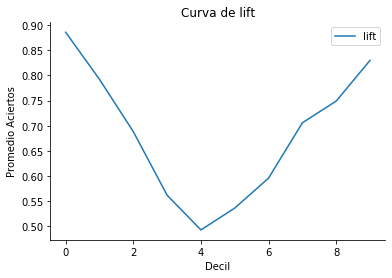

              precision    recall  f1-score   support

      desvio       0.68      0.69      0.69      8214
   no_desvio       0.69      0.68      0.68      8249

    accuracy                           0.68     16463
   macro avg       0.68      0.68      0.68     16463
weighted avg       0.68      0.68      0.68     16463



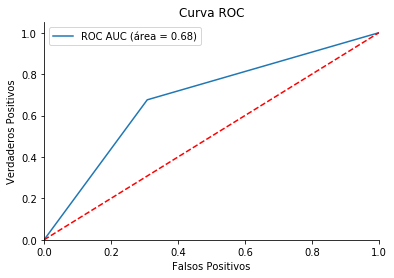

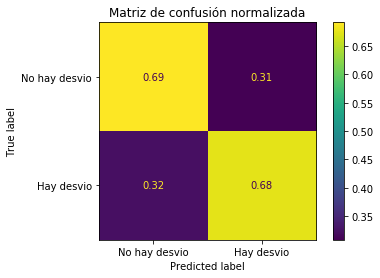

,peso,nombre,peso_norm
208,-58.004020,ALLSKY_SFC_SW_DWN,10.340969
137,57.462736,KT,10.244469
204,8.743082,cmg_desv_win12_min,1.558718
105,6.970813,cmg_real_win24_mean,1.242758
63,-6.870932,cmg_desv_pct_win24_std,1.224951
109,6.487263,cmg_prog_win168_max,1.156551
46,6.346959,cmg_desv_win168_min,1.131537
45,5.305296,cmg_real_win12_max,0.945829
53,-5.089887,cmg_prog_lag6,0.907426
13,4.686440,cmg_prog_win12_std,0.835500


In [40]:
######### Entrenamos la regresión logística y calculamos las métricas
lr_clf1 = LogisticRegression(C=1e-05, penalty = "none", solver='newton-cg')
lr_clf1.fit(X_train,y_train)
y_pred =lr_clf1.predict(X_test)
y_pred_prob = [x[1] for x in lr_clf1.predict_proba(X_test)]
plot_classification_analysis(lr_clf1,X_test,y_test,y_pred,y_pred_prob)


######## Calculamos la importancia de las características de acuerdo al peso de las variables
importancia_modelo = pd.DataFrame(lr_clf1.coef_.transpose(),columns =["peso"])
importancia_modelo["nombre"] = X_train.columns

importancia_modelo["peso_norm"] = abs(importancia_modelo["peso"]/importancia_modelo["peso"].sum())
importancia_modelo.sort_values(by="peso_norm",ascending = False,inplace= True)
importancia_modelo[0:10]

Análisis de los resultados:
1. Métricas
    Con respecto al modelo 2, el modelo 3 no mejora con respecto a la clasificación 
2. Con respecto a la importancia de las características
    1. La primeras dos variables más importantes están relacionadas al clima. La más importante es ALLSKY_SFC_SW_DWN con un impacto negativo y KT con un impacto positivo.
    
 En conclusión, vemos que el modelo no gano poder predictivo y sin embargo las variables relacionadas al clima adquieren mucha relevancia.

# Reflexión
¿Por qué sería bueno utilizar un modelo como este para anticiparse a desvíos de precios de la energía?<br>

Un modelo como este podría ser utilizado para diseñar de mejor manera el sistema de distribución de energía electrica. 
En particular ayudaría los costos adecuados para comprar energía

¿Qué casos de uso te imaginas podrían beneficiarse teniendo acceso a un modelo como este?<br>
Este modelo se podría utilizar para determinar que fenómenos meteorológicos tienen un mayor impacto en el precio 
y poder apalancar esta información con predicciones de clima, radiación, etc.